In [412]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.optimize as opt

from datetime import datetime

In [413]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [414]:
data_one_side = []
data_stat = []
data_rot = []

In [415]:
header = "now,intensity,humidity,temperature,temperature_from_humidity,temperature_from_pressure,pressure,orientation_roll,orientation_pitch,orientation_yaw,compass,compass_raw_x,compass_raw_y,compass_raw_z,gyro_roll,gyro_pitch,gyro_yaw,gyro_raw_x,gyro_raw_y,gyro_raw_z,accelerometer_raw_x,accelerometer_raw_y,accelerometer_raw_z,accelerometer_roll,accelerometer_pitch,accelerometer_yaw\n"

def append_headers(i_start, i_end):
    for i in range(i_start, i_end):
        if i < 10:
            f = open(f"data0{i}.csv", "r+")
        else:
            f = open(f"data{i}.csv", "r+")
        content = f.read()
        f.seek(0, 0)
        f.write(header + content)
        f.close()


In [416]:
def load_data(path):
    for i in range(1, 2*num_runs+1):
        if i < 10:
            filename = f"data0{i}.csv"
        else:
            filename = f"data{i}.csv"

        if i % 2 == 1:
            data_stat.append(pd.read_csv(path + filename).dropna())
        else:
            data_rot.append(pd.read_csv(path+filename).dropna())


In [417]:
def calculate_time(data, i):
    data[i]["now"] = pd.to_datetime(data[i]["now"])
    data[i]["time"] = (data[i]['now'] - data[i]['now'][0]).dt.total_seconds()

In [418]:
def calculate_omega(data, i):
    calculate_time(data, i)
    data[i]['accelerometer_yaw'] = data[i]['accelerometer_yaw'].apply(np.deg2rad)
    data[i]["accelerometer_yaw"] = np.unwrap(data[i]["accelerometer_yaw"])
    data[i]["omega"] = data[i]["accelerometer_yaw"].diff() / data[i]["time"].diff()

In [419]:
def calculate_omega2(data, i):
    calculate_time(data, i)
    data[i]["yaw_rad"] = data[i]["gyro_yaw"].apply(np.deg2rad)
    data[i]["yaw_rad"] = np.unwrap(data[i]["yaw_rad"])
    data[i]["omega"] = data[i]["yaw_rad"].diff() / data[i]["time"].diff()

In [420]:
def plot_omega(data, i):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    fig.suptitle("Graphs of rotational speed as a function of time", fontsize=24)

    # ax.set_ylim([-8, 8])
    ax.scatter(data[i]["time"], data[i]["gyro_raw_z"])
    ax.title.set_text("")
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Rotational speed [rad / s]")

In [421]:
def calculate_omegas(data):
    for i in range(len(data)):
        calculate_omega(data, i)

In [422]:
num_runs = 3
load_data("")
calculate_omegas(data_rot)
calculate_omegas(data_stat)
calculate_omegas(data_one_side)


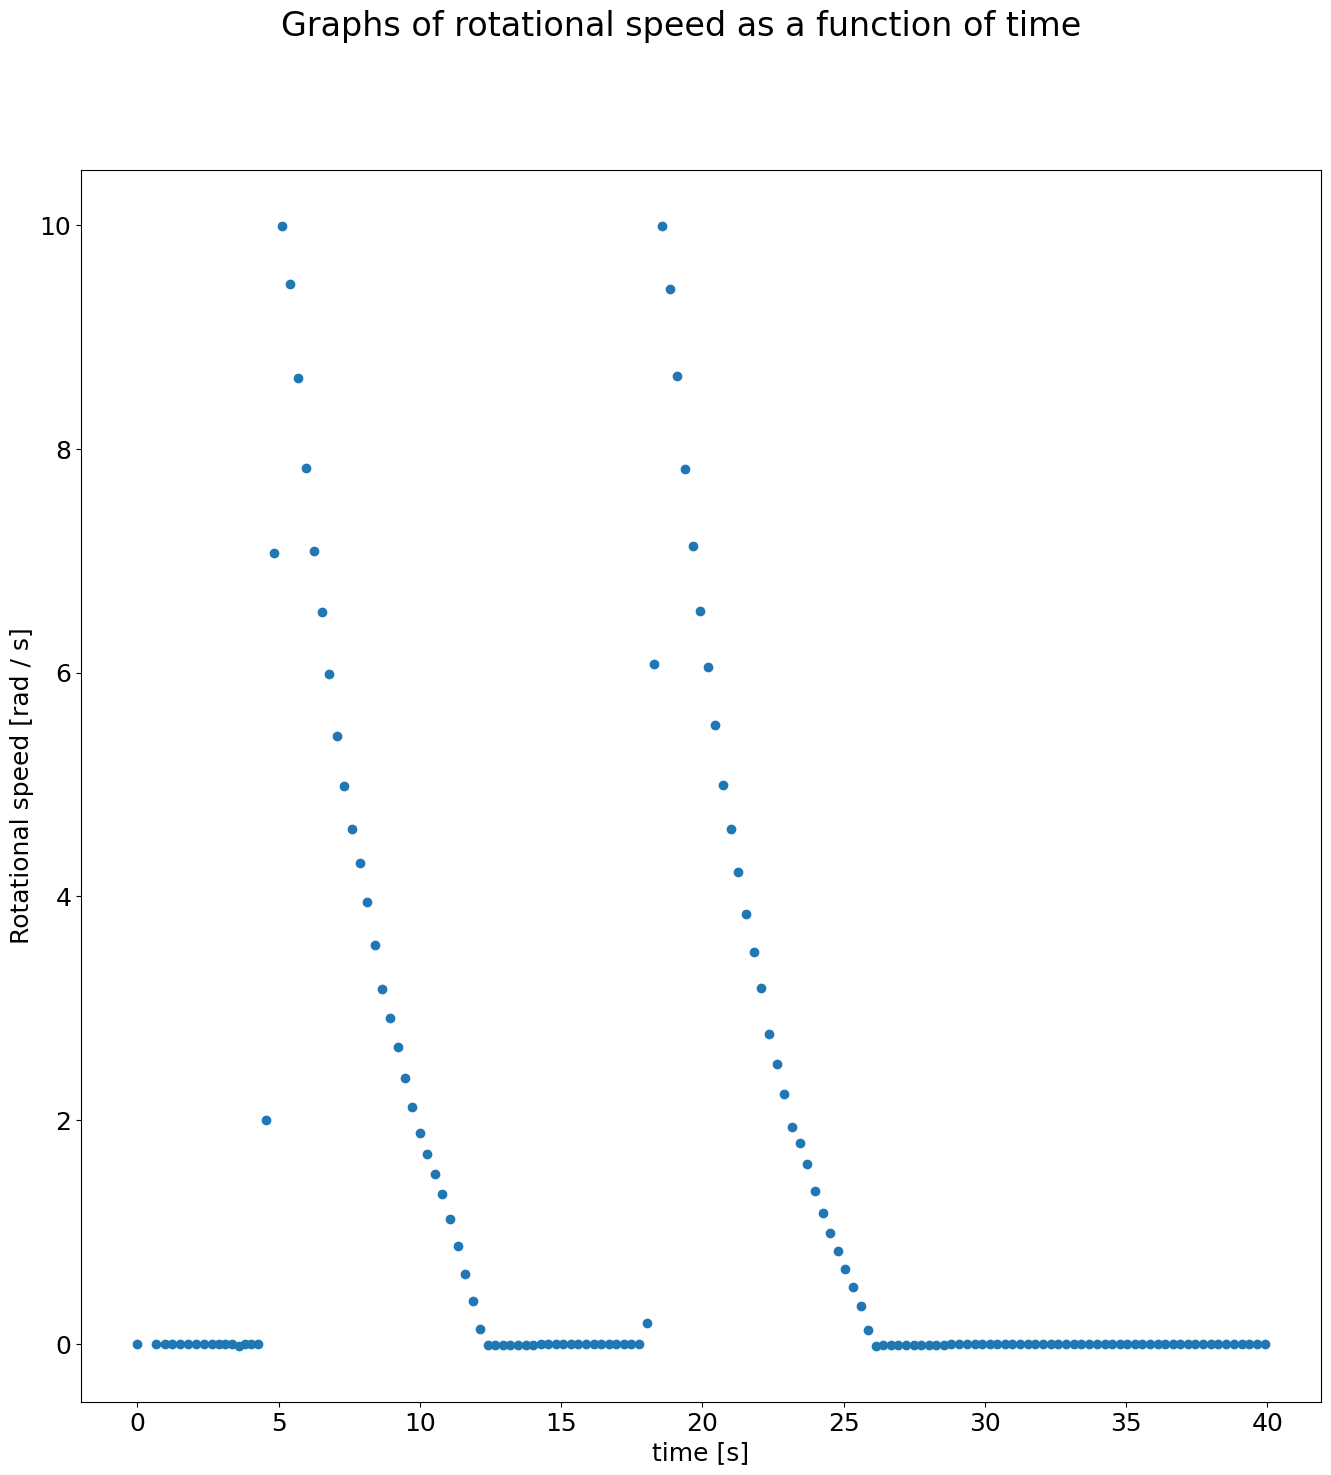

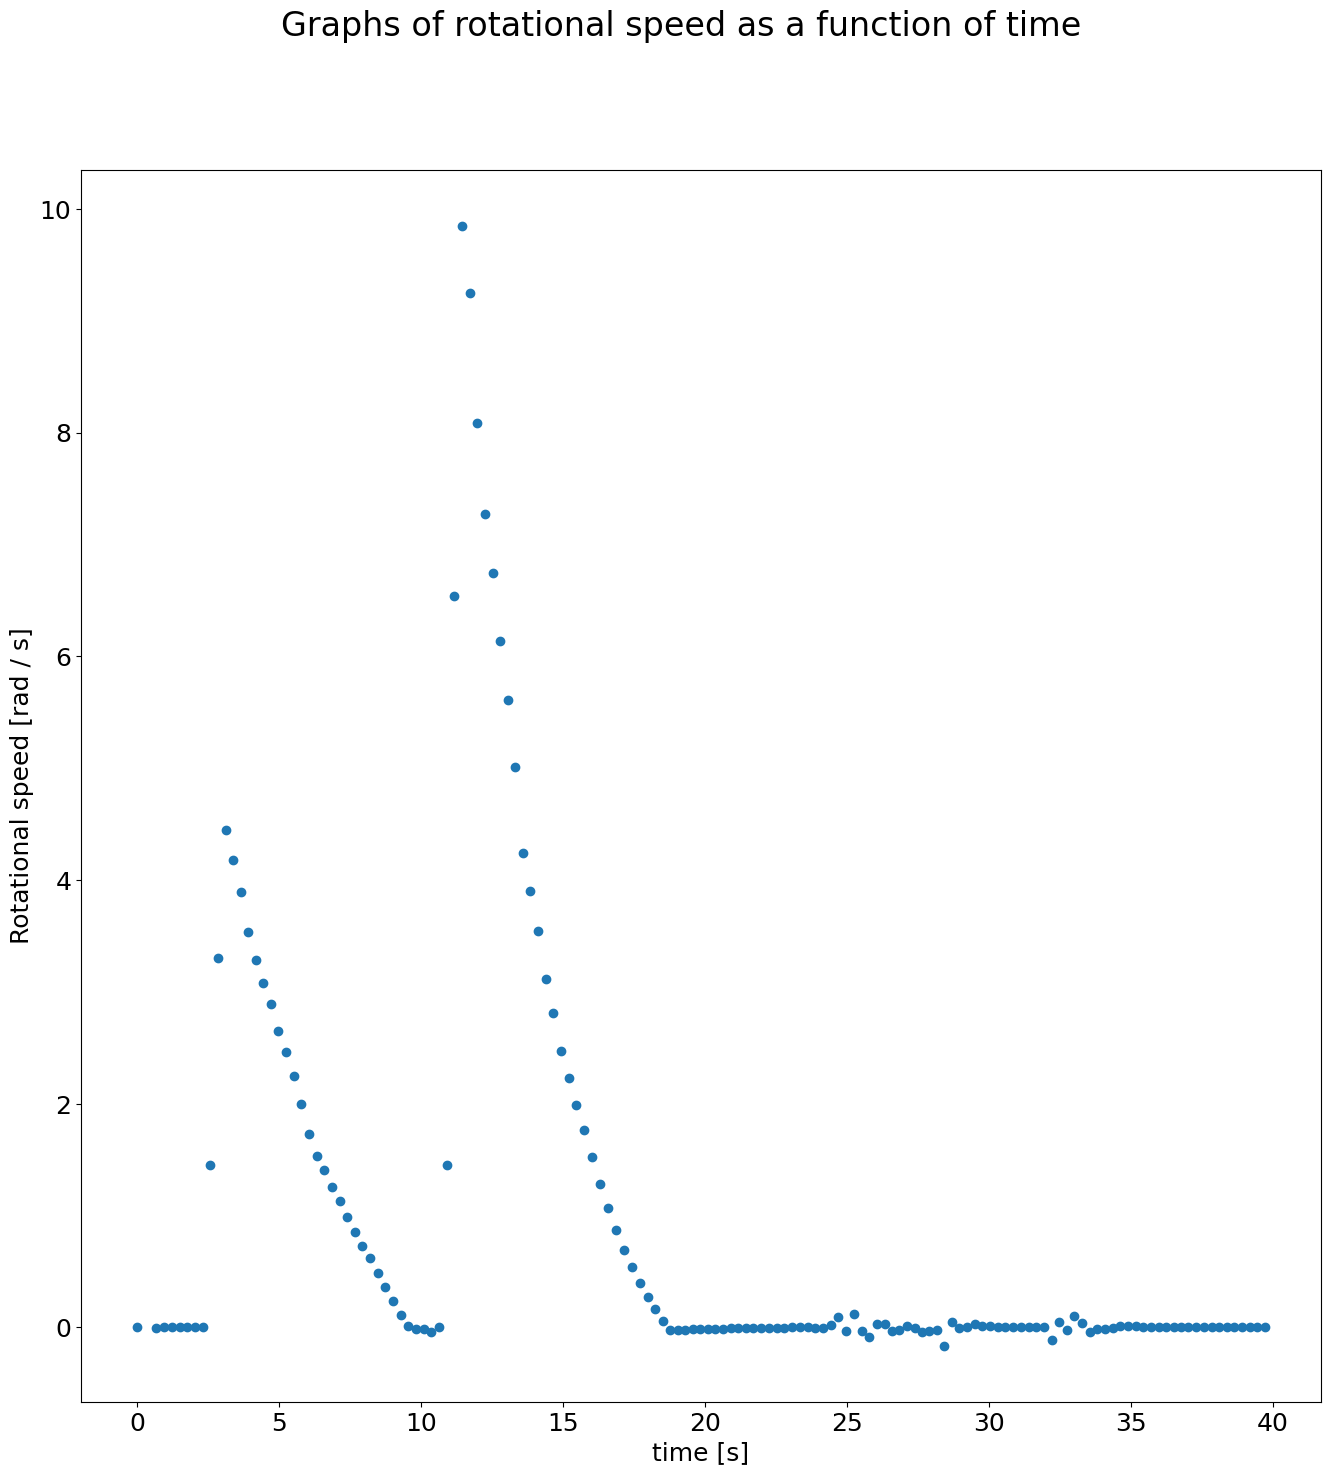

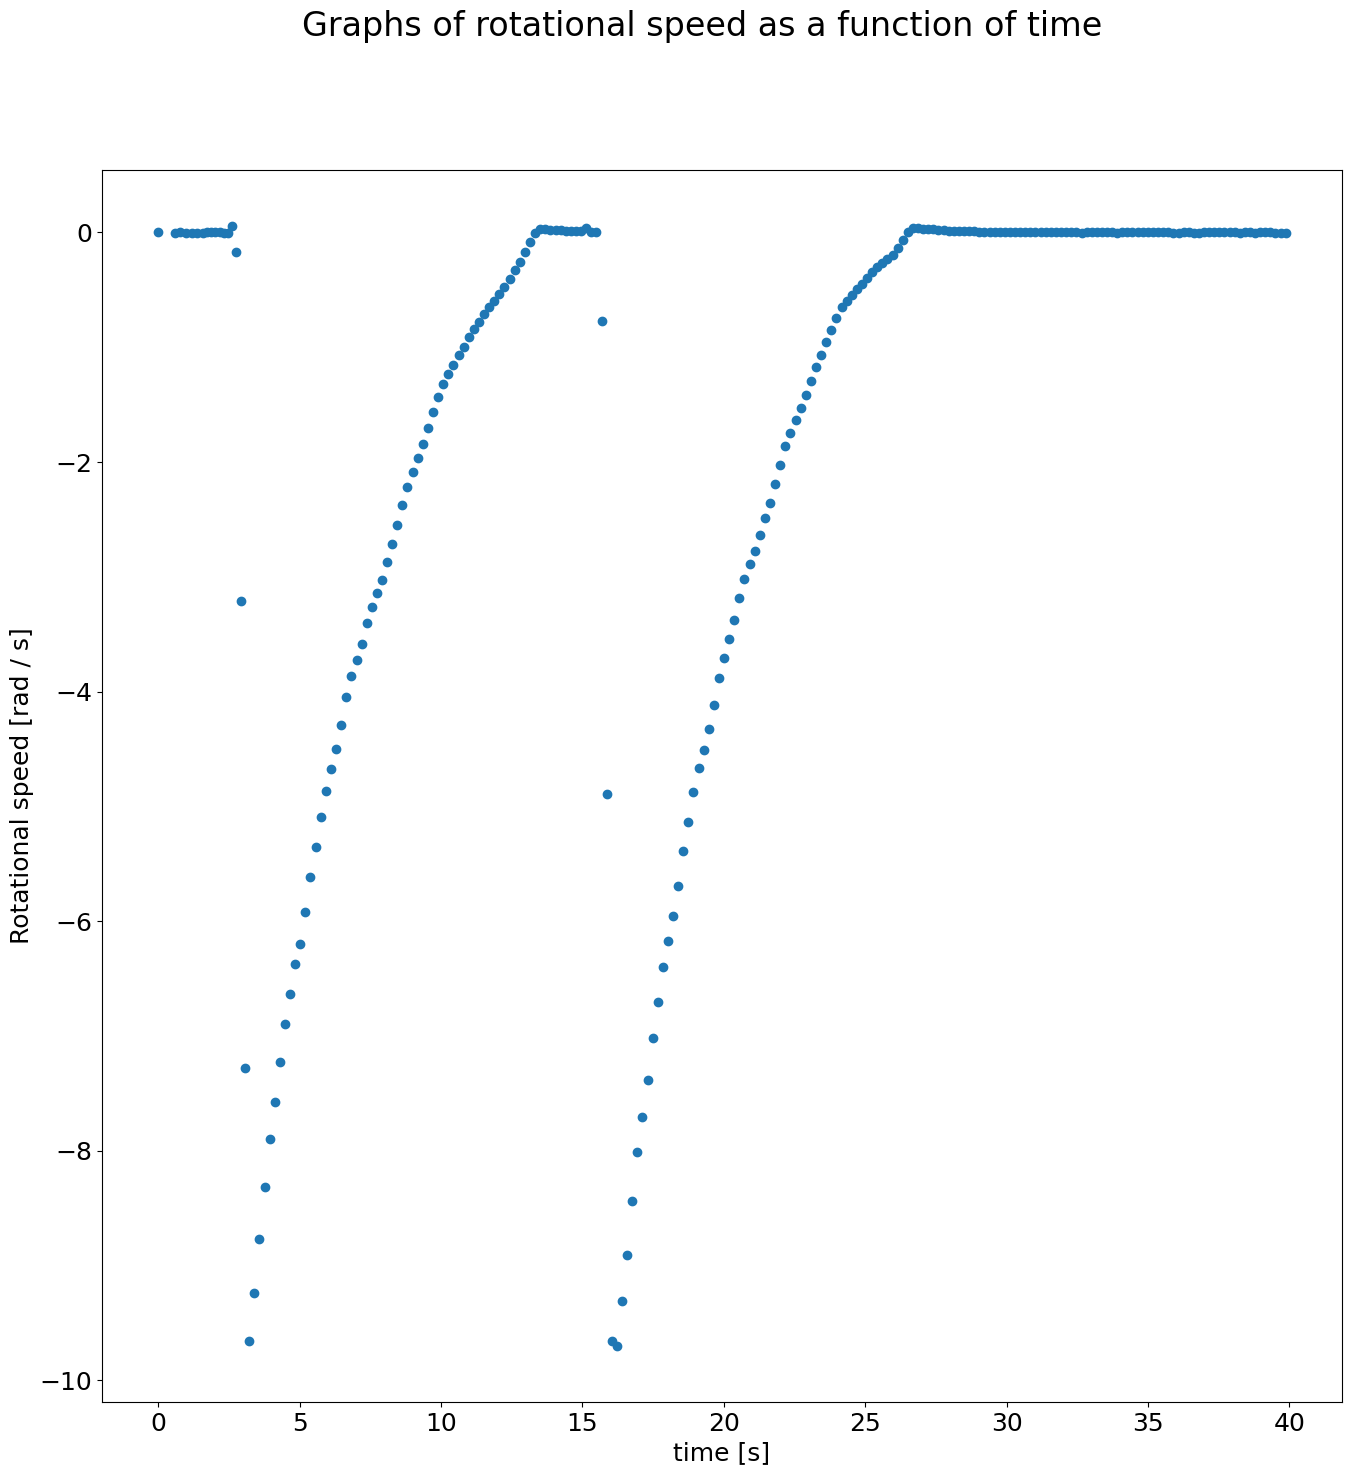

In [423]:
for i in range(num_runs):
    plot_omega(data_rot, i)

In [424]:
def plot_intensity(data, i):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    fig.suptitle("Graphs of intensity as a function of time", fontsize=24)

    # ax.set_ylim([0.8, 0.92])
    ax.scatter(data[i]["time"], data[i]["intensity"])
    ax.title.set_text("")
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Intensity [%]")

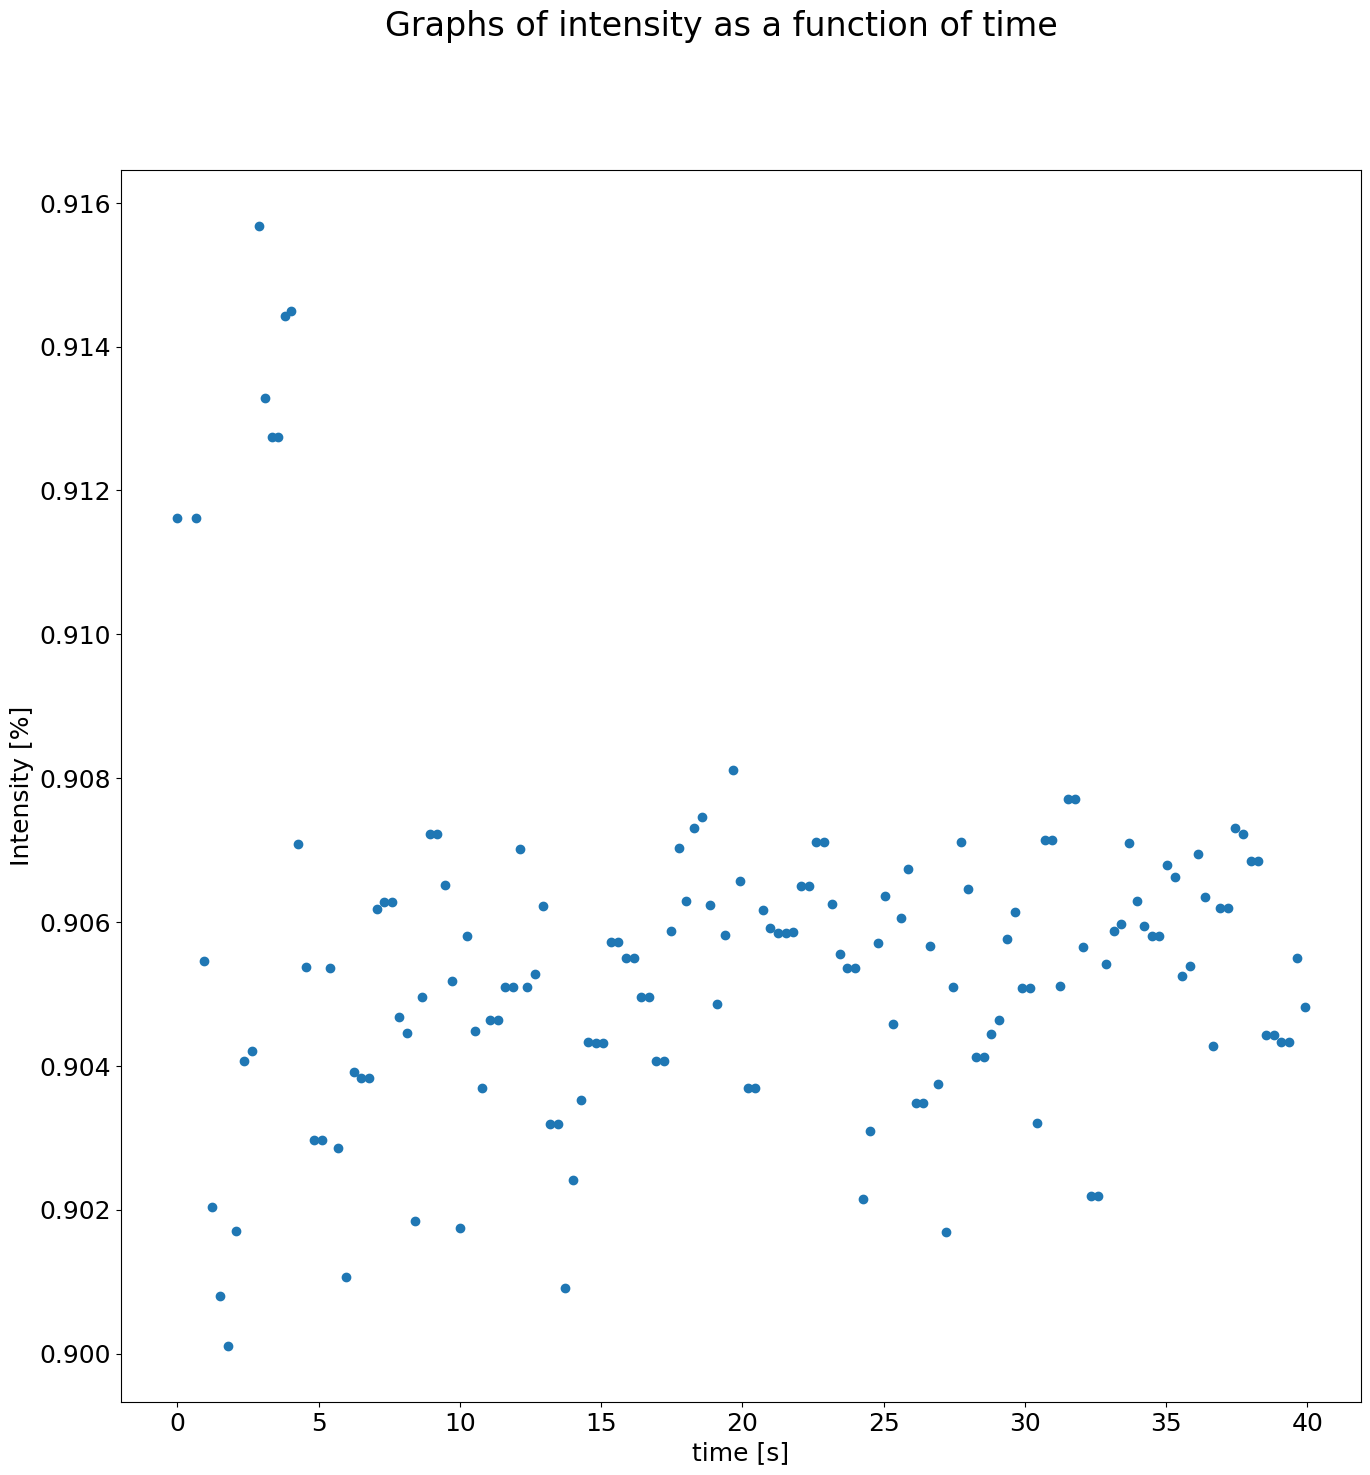

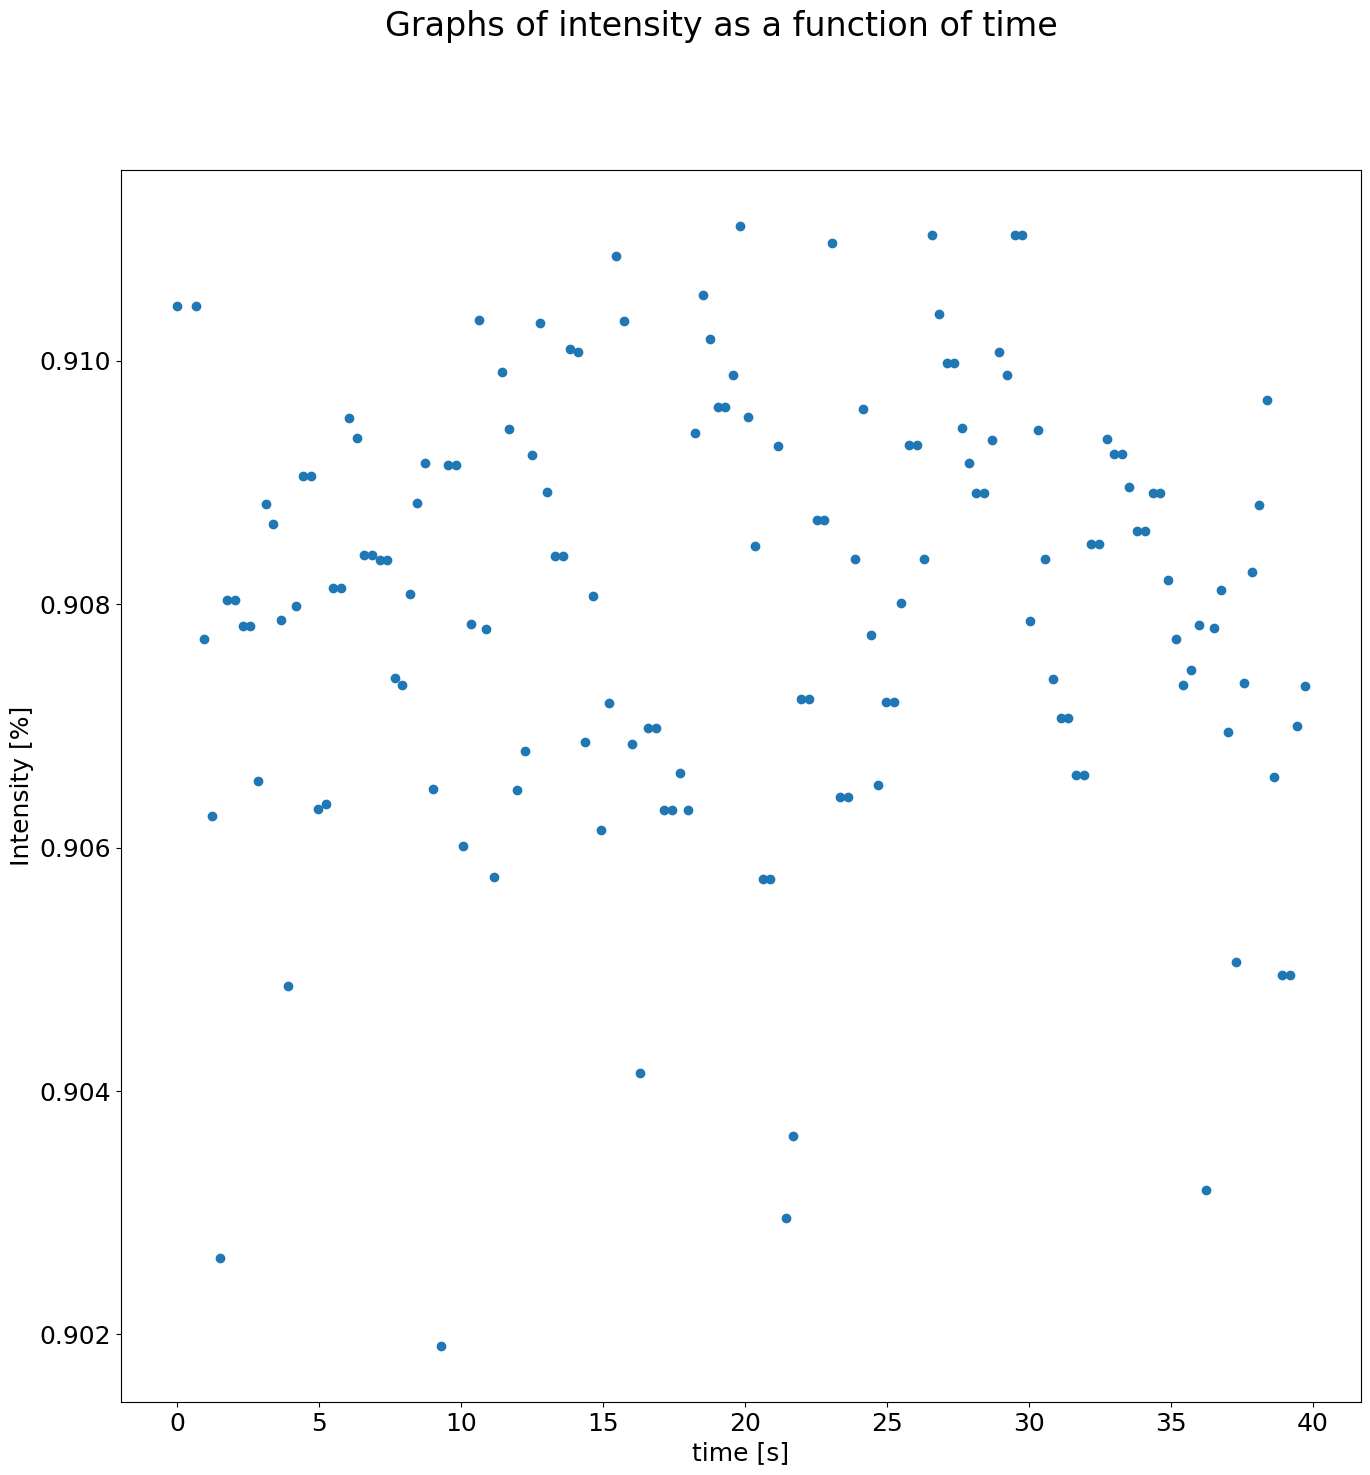

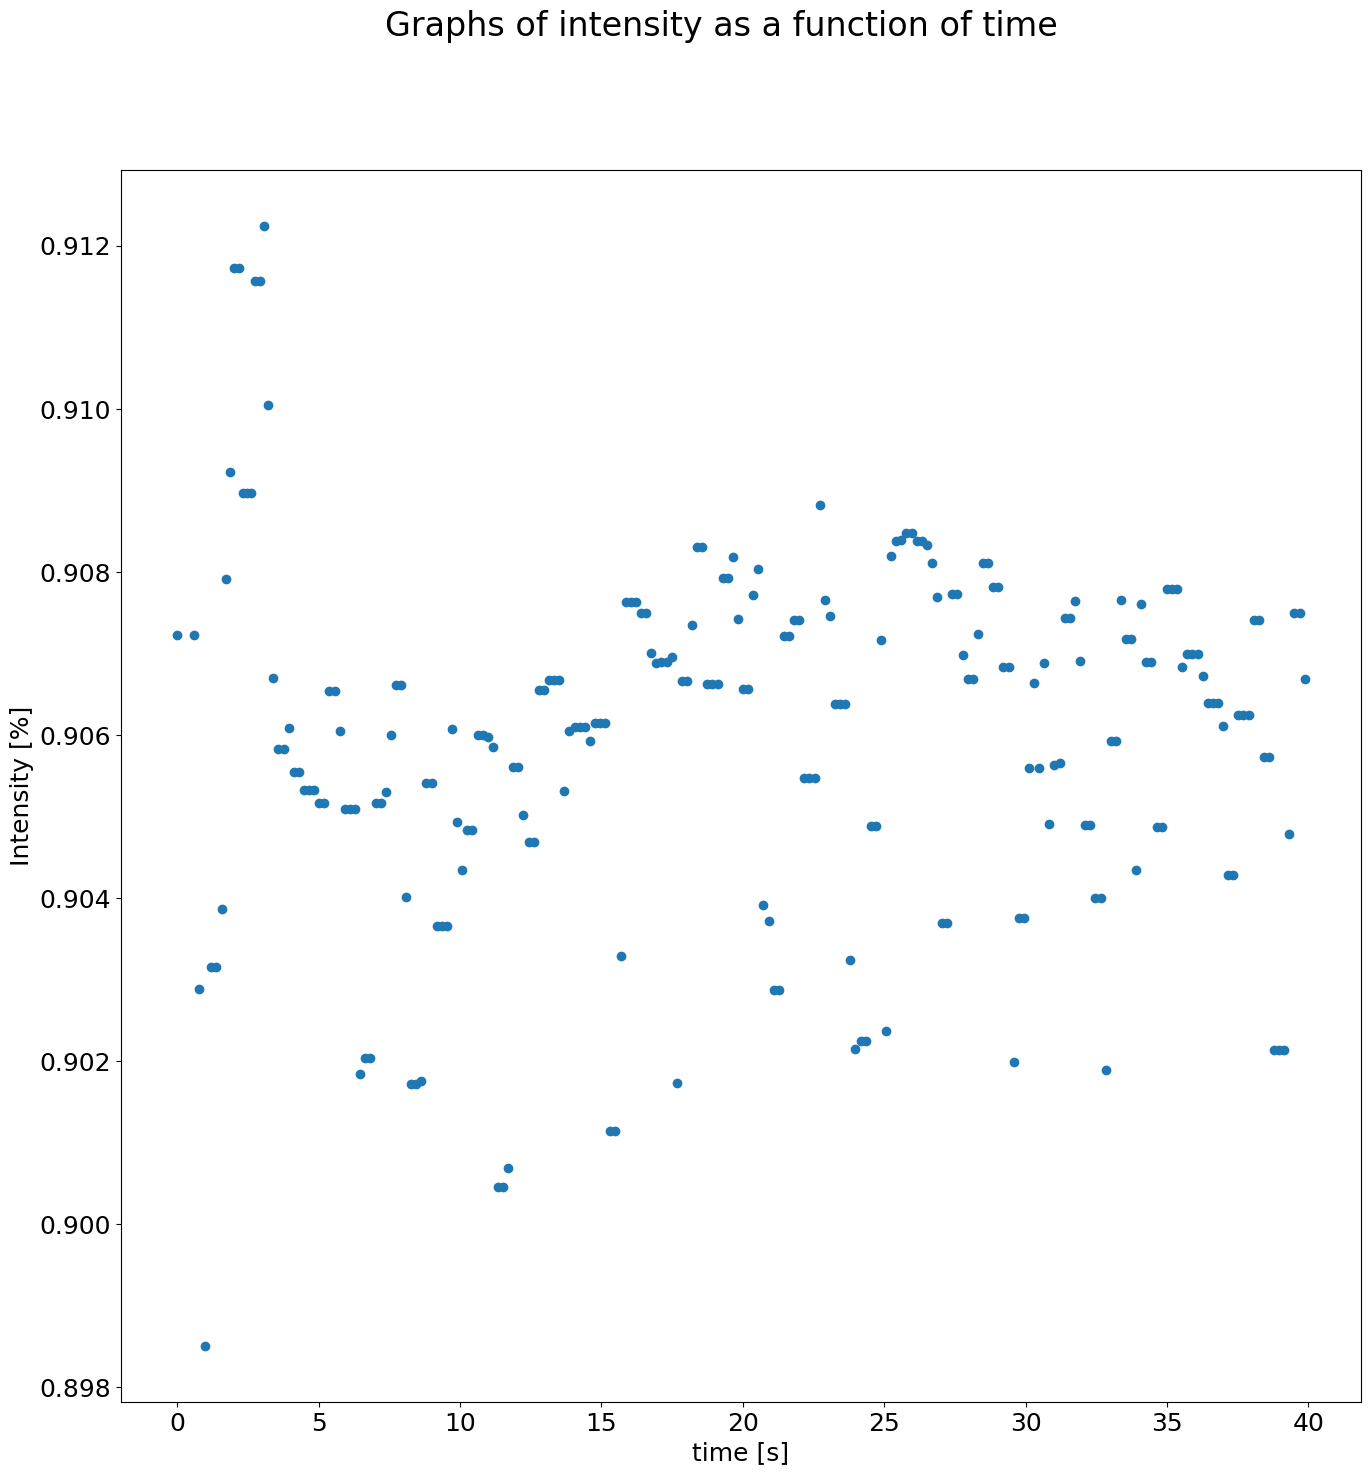

In [425]:
for i in range(num_runs):
    plot_intensity(data_rot, i)

In [426]:
def intensity_vs_omega_plot(data, i):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    fig.suptitle("Graphs of intensity as a function of time", fontsize=24)

    # ax.set_ylim([0.8, 0.92])
    ax.scatter(abs(data[i]["omega"]), data[i]["intensity"])
    ax.title.set_text("")
    ax.set_xlabel("omega [rad / s]")
    ax.set_ylabel("Intensity [%]")

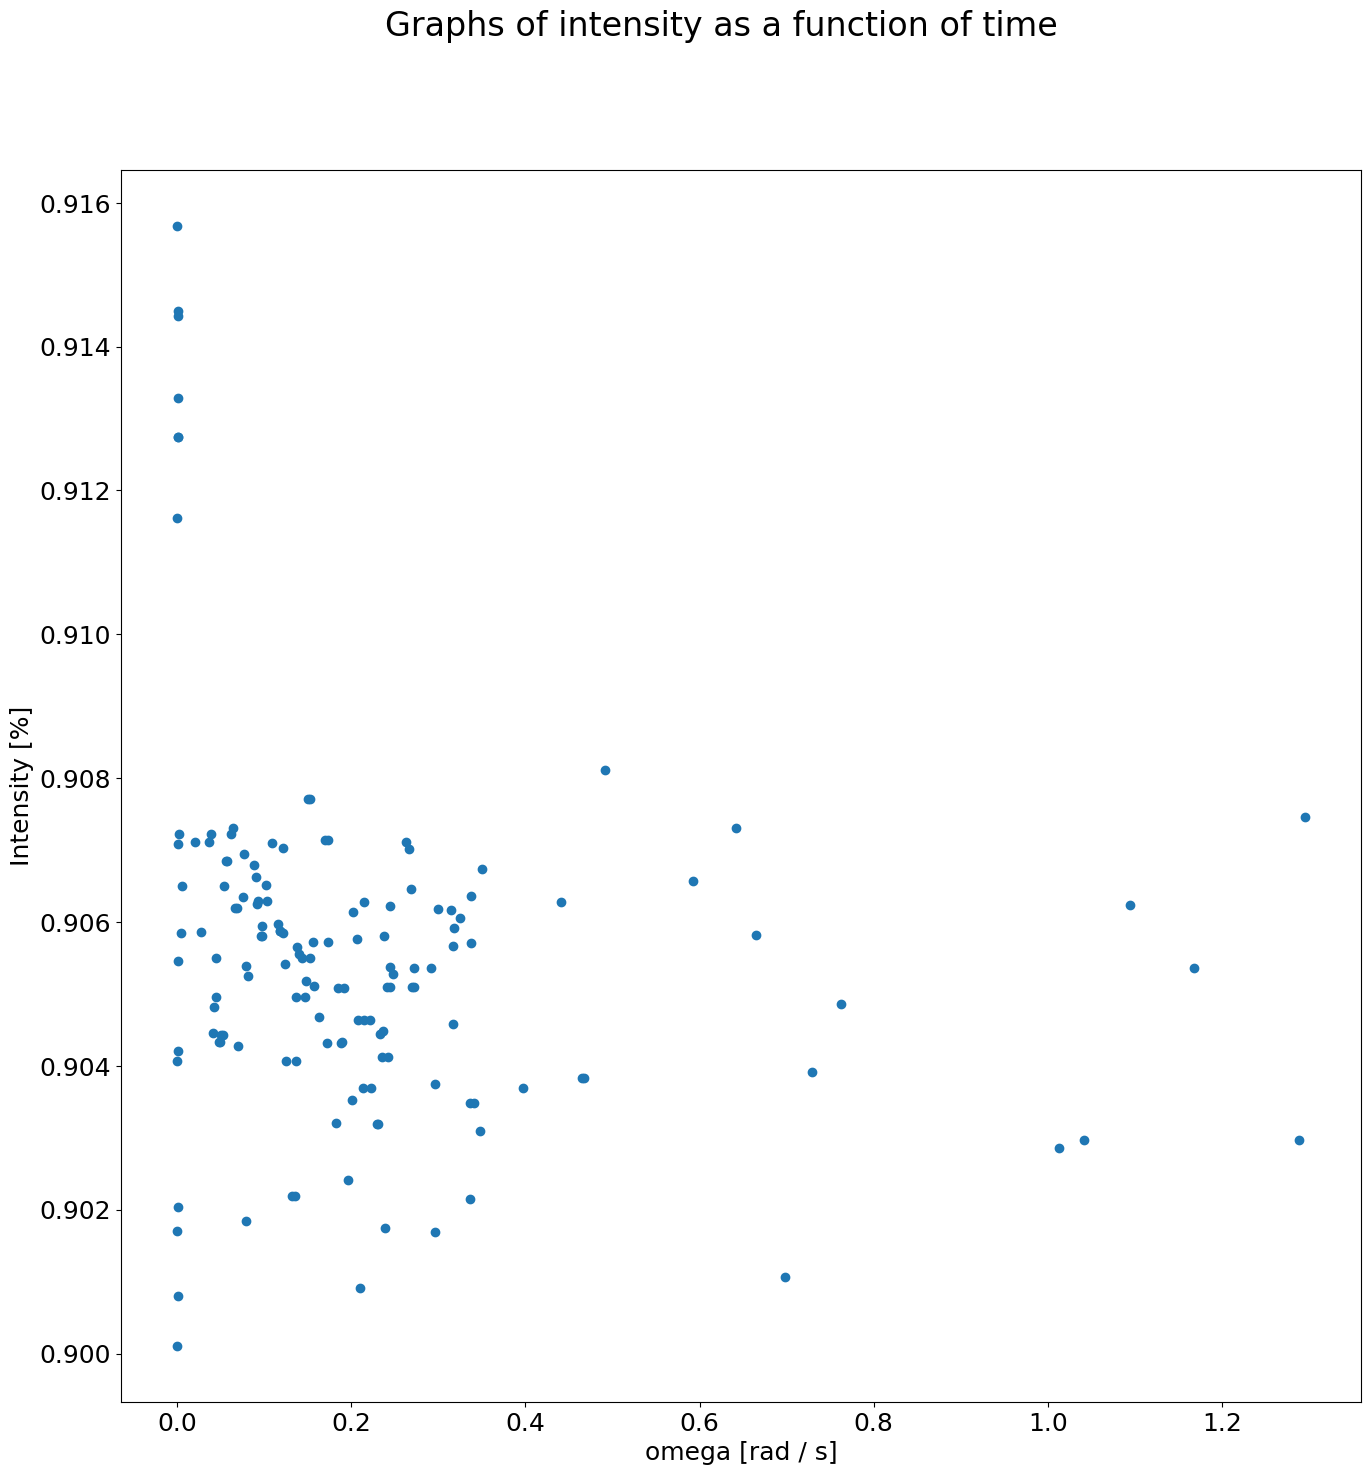

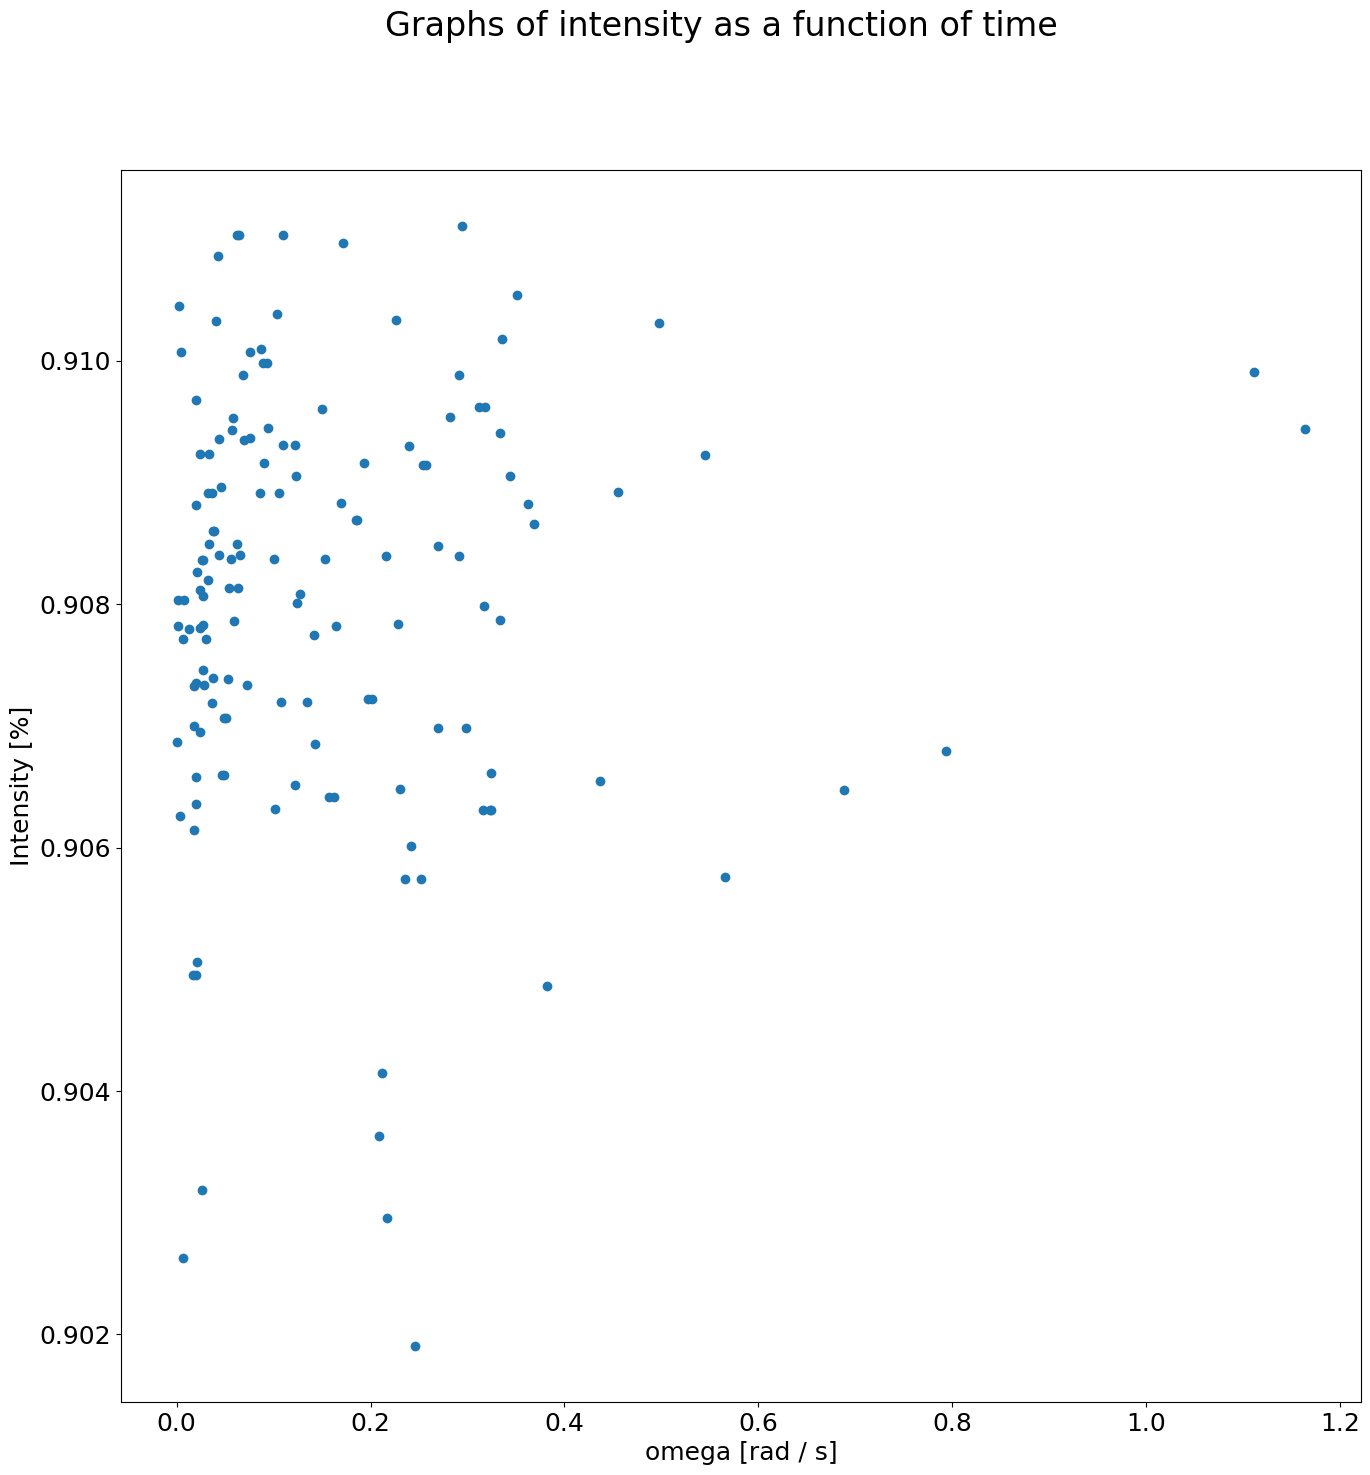

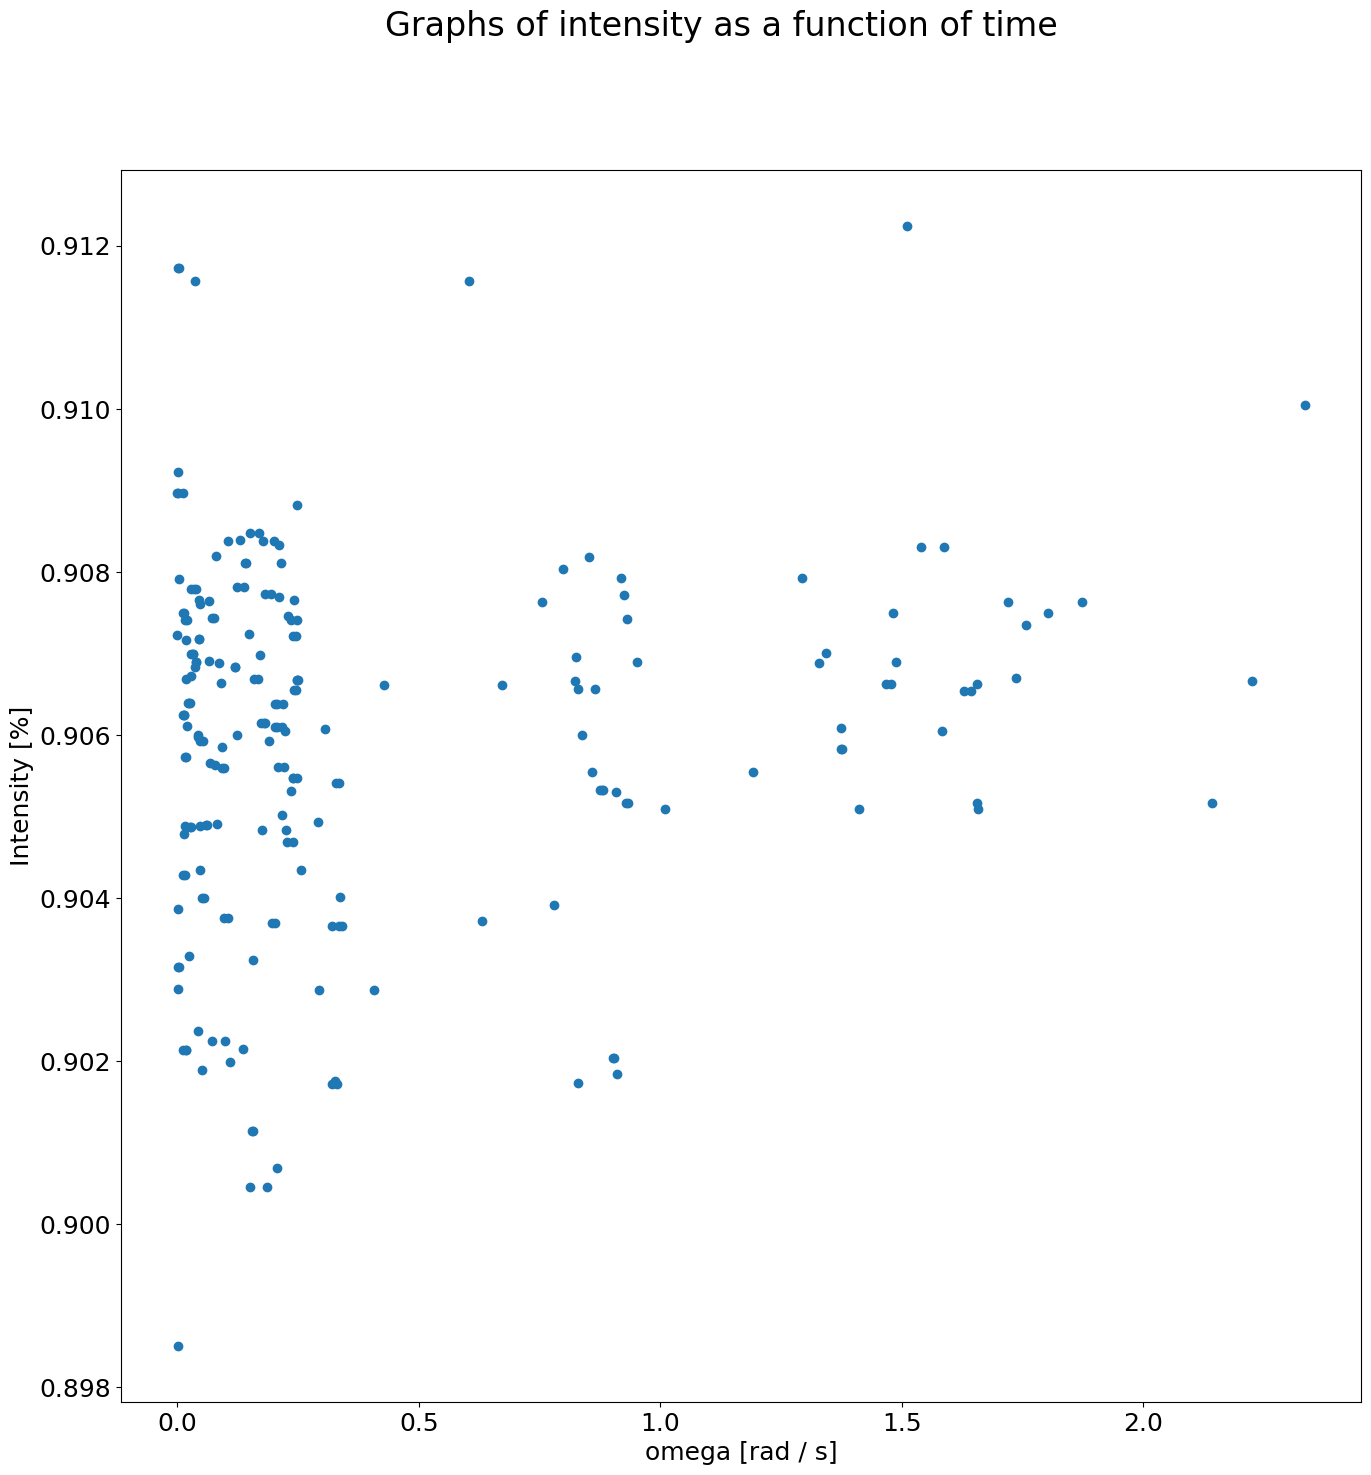

In [427]:
for i in range(num_runs):
    intensity_vs_omega_plot(data_rot, i)